In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json

In [58]:
import likelihood 

def binding_curve(K,X_concs):
    """
    Simple, saturating binding curve.

    K: association constant
    X_concs: vector of X concentrations

    """
    
    return K*X_concs/(1 + K*X_concs)


class LikelihoodModel:
    
    def __init__(self,Y_obs,real_model,*args,**kwargs):

        self._Y_obs = Y_obs
        self._real_model = real_model
        self._model_args = args
        self._model_kwargs = kwargs
                
    def residual(self,params):
        
        return self._real_model(*params,
                                *self._model_args,
                                **self._model_kwargs) - self.Y_obs
    
    
param_guesses = [1]
X_concs = 
bounds = None
    
x = YourModel(X_concs)
ml_fitter = likelihood.MLFitter()
ml_fit = ml_fitter.fit(x.observable,param_guesses,bounds)

NameError: name 'param_guesses' is not defined

In [64]:

def x(*args):
    print(*args)

x(None,None)


None None


## Write test data
<h3><font color="red">WARNING: this will update test files.</font></h3>

This may cause tests that depend on fit-values to fail.  To run, uncomment `write_new_test_data()` below.

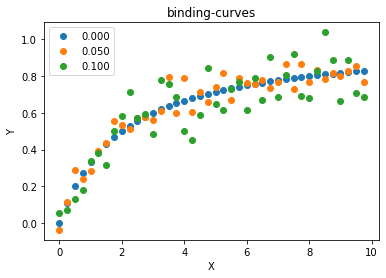

In [65]:

def write_new_test_data(K=0.5,prefix="binding-curves"):
       
    test_files = []
    X_concs = np.arange(0,10,0.25)
    fig, ax = plt.subplots()
    for noise in [0.0,0.05,0.1]:
        name = f"{noise:.3f}"

        frac_sat = binding_curve(X_concs,K) + np.random.normal(0,noise,len(X_concs))


        df = pd.DataFrame({"X":X_concs,
                       "Y":frac_sat})

        ax.plot(df.X,df.Y,"o",label=name)
        
        test_files.append(f"{prefix}_noise-{name}.csv")
        
        df.to_csv(test_files[-1])
        
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(f"{prefix}")
    
    fig.savefig(f"{prefix}.pdf")
    
    json_dict = {"input_params":(K,),
                 "test_files":test_files}
    
    json.dump(json_dict,open(f"{prefix}.json","w"))
    
    plt.show()
    
    
write_new_test_data()

In [56]:
json.load(open("binding-curves.json"))["input_params"]

[0.5]

In [36]:
pd.read_csv("binding-curve_noise-0.000.csv",index_col=0)

,X,Y
0,0.00,0.000000
1,0.25,0.111111
2,0.50,0.200000
3,0.75,0.272727
4,1.00,0.333333
5,1.25,0.384615
6,1.50,0.428571
7,1.75,0.466667
8,2.00,0.500000
9,2.25,0.529412
